In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 212.3MB 72kB/s 
     |████████████████████████████████| 204kB 38.4MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=5c5743f797e1e96fc848f6347b131f320d46a04c76e158c1163be5aca245569f
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
cur_path = "/content/drive/MyDrive/2021_Spring/Big_Data/Final_project/"
os.chdir(cur_path)
!pwd

/content/drive/MyDrive/2021_Spring/Big_Data/Final_project


Create spark session

In [114]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: ignored

In [115]:
df = spark.read.csv("netflix_titles.csv", header=True)

In [116]:
df.show(5)

+-------+-------+-----+-----------------+--------------------+-------------+-----------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|title|         director|                cast|      country|       date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+-----+-----------------+--------------------+-------------+-----------------+------------+------+---------+--------------------+--------------------+
|     s1|TV Show|   3%|             null|João Miguel, Bian...|       Brazil|  August 14, 2020|        2020| TV-MA|4 Seasons|International TV ...|In a future where...|
|     s2|  Movie| 7:19|Jorge Michel Grau|Demián Bichir, Hé...|       Mexico|December 23, 2016|        2016| TV-MA|   93 min|Dramas, Internati...|After a devastati...|
|     s3|  Movie|23:59|     Gilbert Chan|Tedd Chan, Stella...|    Singapore|December 20, 2018|        2011|     R|   78 min|Horror Movies, In...|When an army recr...

In [117]:
df.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



Preprocess the datatype

In [118]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import col, split, slice
from operator import itemgetter
import seaborn as sns

In [119]:
tokenizer = Tokenizer(inputCol="description", outputCol="des_list")
# regexTokenizer = RegexTokenizer(inputCol="sentence", outputCol="words", pattern="\\W")
# alternatively, pattern="\\w+", gaps(False)
# countTokens = udf(lambda words: len(words), IntegerType())
tokenized = tokenizer.transform(df)

In [125]:
remover = StopWordsRemover(inputCol="des_list", outputCol="filtered_des_list")
remover.transform(tokenized)

DataFrame[show_id: string, type: string, title: string, director: string, cast: string, country: string, date_added: string, release_year: string, rating: string, duration: string, listed_in: string, description: string, des_list: array<string>, filtered_des_list: array<string>]

In [126]:
df = remover.transform(tokenized)

In [127]:
df = df.na.fill("Unknown",["director"]) \
    .na.fill("Unknown",["cast"])

In [128]:
df = df.withColumn("cast_list", split(col("cast"), ", "))
df = df.withColumn("director_list", split(col("director"), ", "))
df = df.withColumn("type_list", split(col("listed_in"), ", "))

In [129]:
df.show()

+-------+-------+------+--------------------+--------------------+--------------------+-----------------+------------+------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|show_id|   type| title|            director|                cast|             country|       date_added|release_year|rating| duration|           listed_in|         description|            des_list|   filtered_des_list|           cast_list|       director_list|           type_list|
+-------+-------+------+--------------------+--------------------+--------------------+-----------------+------------+------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     s1|TV Show|    3%|             Unknown|João Miguel, Bian...|              Brazil|  August 14, 2020|        2020| TV-MA|4 Seasons|International TV

### Top directors & actors

#### All the shows

In [168]:
direct_counter = (df
           .select("director")
           .rdd
           # join all strings in the list and then split to get each word
           .map(lambda x: " ".join(x).split(", ")) 
           .flatMap(lambda x: x)
           # make a tuple for each word so later it can be grouped by to get its frequency count
           .map(lambda x: (x, 1))
           .reduceByKey(lambda a,b: a+b)
           .collectAsMap())

In [169]:
sort_director = sorted(direct_counter.items(), key=itemgetter(1), reverse=True)
director_top10 = sort_director[1:11]
df_director_top10 = pd.DataFrame(director_top10, columns=['Director','Total Number'])

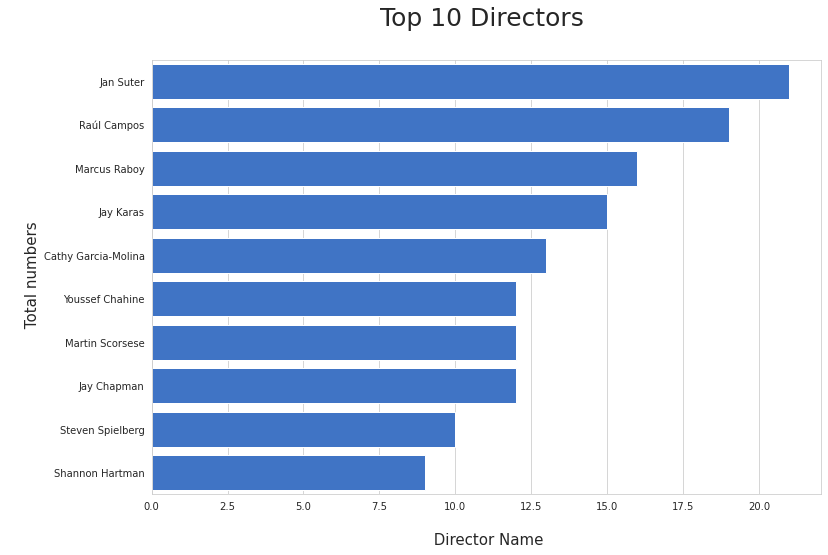

In [180]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
fig = sns.barplot(x="Total Number", y="Director", data=df_director_top10, color="#2a6fdb")
fig.axes.set_title("Top 10 Directors \n",fontsize=25)
fig.set_xlabel("\n Director Name",fontsize=15)
fig.set_ylabel("\n Total numbers",fontsize=15)
fig.tick_params(labelsize=10)
plt.show()

In [197]:
cast_counter = (df
           .select("cast")
           .rdd
           # join all strings in the list and then split to get each word
           .map(lambda x: " ".join(x).split(", ")) 
           .flatMap(lambda x: x)
           # make a tuple for each word so later it can be grouped by to get its frequency count
           .map(lambda x: (x, 1))
           .reduceByKey(lambda a,b: a+b)
           .collectAsMap())

In [173]:
sort_cast = sorted(cast_counter.items(), key=itemgetter(1), reverse=True)

In [174]:
sort_cast = sorted(cast_counter.items(), key=itemgetter(1), reverse=True)
cast_top10 = sort_cast[1:11]
df_cast_top10 = pd.DataFrame(cast_top10, columns=['Actor/Actress','Total Number'])

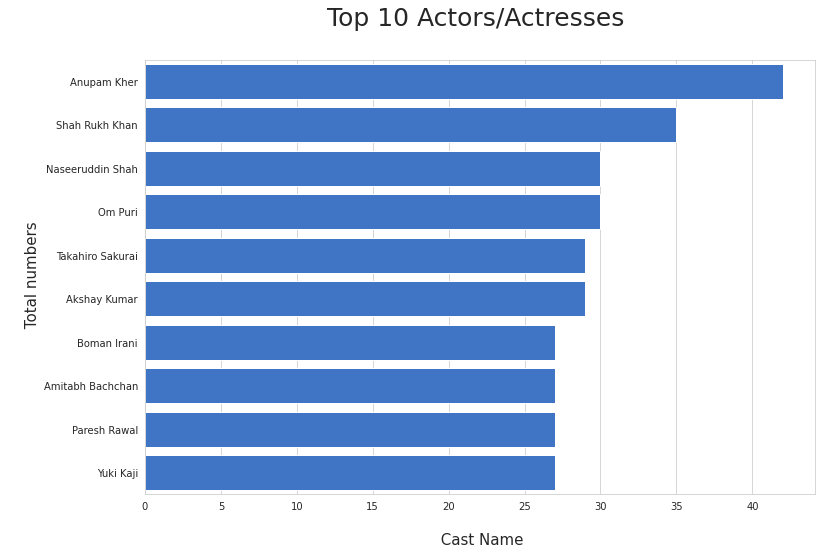

In [179]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
fig = sns.barplot(x="Total Number", y="Actor/Actress", data=df_cast_top10, color="#2a6fdb")
fig.axes.set_title("Top 10 Actors/Actresses \n",fontsize=25)
fig.set_xlabel("\n Cast Name",fontsize=15)
fig.set_ylabel("\n Total numbers",fontsize=15)
fig.tick_params(labelsize=10)
plt.show()

#### TV shows & Movies

In [205]:
director_TV_counter = (df.filter("type == 'TV Show'")
           .select("director")
           .rdd
           # join all strings in the list and then split to get each word
           .map(lambda x: " ".join(x).split(", ")) 
           .flatMap(lambda x: x)
           # make a tuple for each word so later it can be grouped by to get its frequency count
           .map(lambda x: (x, 1))
           .reduceByKey(lambda a,b: a+b)
           .collectAsMap())

In [206]:
director_Movie_counter = (df.filter("type == 'Movie'")
           .select("director")
           .rdd
           # join all strings in the list and then split to get each word
           .map(lambda x: " ".join(x).split(", ")) 
           .flatMap(lambda x: x)
           # make a tuple for each word so later it can be grouped by to get its frequency count
           .map(lambda x: (x, 1))
           .reduceByKey(lambda a,b: a+b)
           .collectAsMap())

In [210]:
director_TV_top10 = sorted(director_TV_counter.items(), key=itemgetter(1), reverse=True)[1:11]
director_Movie_top10 = sorted(director_Movie_counter.items(), key=itemgetter(1), reverse=True)[1:11]

In [211]:
df_director_TV_top10 = pd.DataFrame(director_TV_top10, columns=['Director','Total Number'])
df_director_Movie_top10 = pd.DataFrame(director_Movie_top10, columns=['Director','Total Number'])

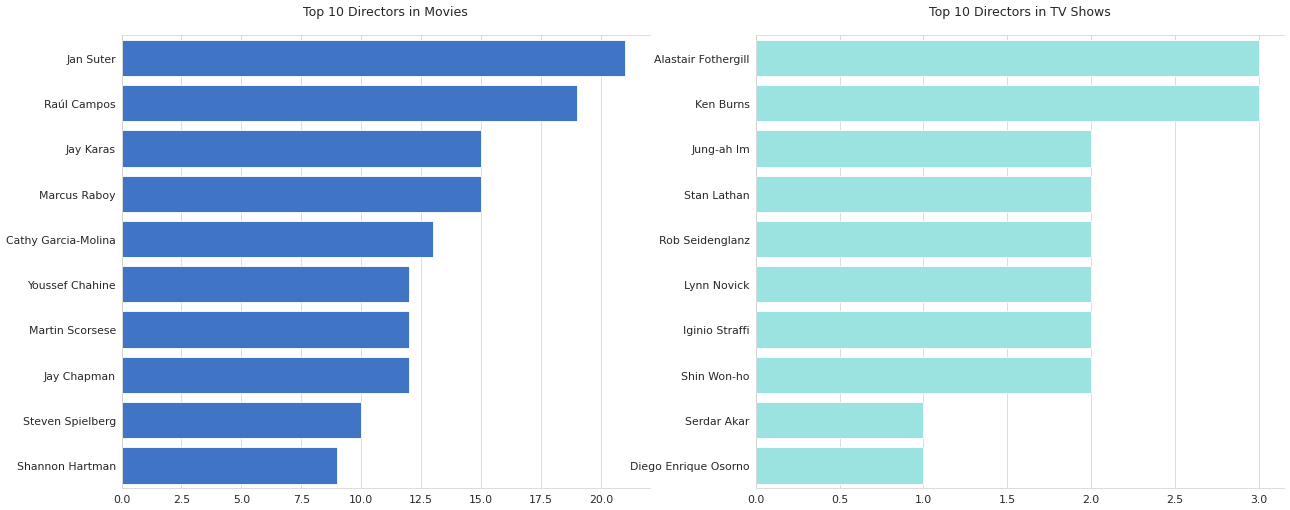

In [224]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 10), dpi=60)


sns.barplot(x="Total Number", y="Director", data=df_director_Movie_top10, ax=axes[0], color="#2a6fdb")
sns.barplot(x="Total Number", y="Director", data=df_director_TV_top10, ax=axes[1], color="#8eefed")


for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title('Top 10 Directors in Movies\n', fontsize=15)
axes[1].set_title('Top 10 Directors in TV Shows\n', fontsize=15)


plt.show()

In [23]:
# from pyspark.sql import functions as F
df_lower = df.select([lower(col(x)).alias(x.lower()) for x in df.columns])